In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Dropout
from tensorflow.keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Ingestion

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
data_path = '/content/gdrive/My Drive/Colab Notebooks/Residential Data/Residential_Cleaned.xlsx'
residential_data = pd.read_excel(data_path)
residential_data.head()

BOROUGH  ... SALE_PRICE_BY_GROSS_SQUARE_FEET
0        1  ...                     1250.000000
1        1  ...                      264.893750
2        1  ...                      513.157895
3        1  ...                      347.459858
4        1  ...                     1021.374459

[5 rows x 24 columns]

## Data Preprocessing & Preliminary Data Analysis

In [ ]:
# define custom classes based on cluster analysis
df = residential_data.copy()
df['Class'] = 0
df.head()

BOROUGH               NEIGHBORHOOD  ... SALE_PRICE_BY_GROSS_SQUARE_FEET  Class
0        1  ALPHABET CITY              ...                     1250.000000      0
1        1  ALPHABET CITY              ...                      264.893750      0
2        1  ALPHABET CITY              ...                      513.157895      0
3        1  ALPHABET CITY              ...                      347.459858      0
4        1  ALPHABET CITY              ...                     1021.374459      0

[5 rows x 25 columns]

In [ ]:
# assign classes based on cluster analysis
df.loc[(df.BLOCK <= 3600) ,'Class'] = 0
df.loc[(df.BLOCK > 3600) & (df.BLOCK <= 8600) ,'Class'] = 1
df.loc[(df.BLOCK > 8600) ,'Class'] = 2

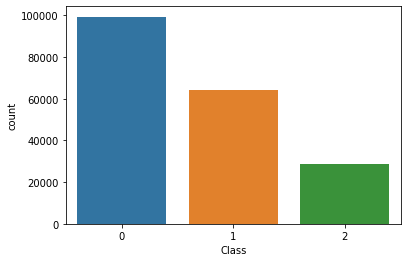

In [ ]:
sns.countplot(x = 'Class',data = df);

In [ ]:
# check for nulls or missing values
df.isna().any()

BOROUGH                            False
NEIGHBORHOOD                       False
BUILDING_CLASS_CATEGORY            False
TAX_CLASS_AT_PRESENT               False
BLOCK                              False
LOT                                False
BUILDING_CLASS_AT_PRESENT          False
ADDRESS                            False
APARTMENT_NUMBER                   False
ZIP_CODE                           False
RESIDENTIAL_UNITS                  False
COMMERCIAL_UNITS                   False
TOTAL_UNITS                        False
LAND_SQUARE_FEET                   False
GROSS_SQUARE_FEET                  False
YEAR_BUILT                         False
TAX_CLASS_AT_TIME_OF_SALE          False
BUILDING_CLASS_AT_TIME_OF_SALE     False
SALE_PRICE                         False
SALE_DATE                          False
IS_APARTMENT                       False
IS_RESIDENTIAL                     False
BUILDING_AGE                       False
SALE_PRICE_BY_GROSS_SQUARE_FEET    False
Class           

In [ ]:
# check for duplicates
df.duplicated().any()

False

## Feature Selection

In [ ]:
# get column names
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE', 'RESIDENTIAL_UNITS',
       'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'LAND_SQUARE_FEET',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
       'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE', 'SALE_DATE',
       'IS_APARTMENT', 'IS_RESIDENTIAL', 'BUILDING_AGE',
       'SALE_PRICE_BY_GROSS_SQUARE_FEET', 'Class'],
      dtype='object')

In [ ]:
final_df = df.drop(columns=['ADDRESS','APARTMENT_NUMBER','ZIP_CODE','TOTAL_UNITS',\
                            'BUILDING_CLASS_AT_PRESENT','IS_APARTMENT','IS_RESIDENTIAL','YEAR_BUILT','TAX_CLASS_AT_PRESENT','SALE_DATE','BLOCK','SALE_PRICE','SALE_PRICE_BY_GROSS_SQUARE_FEET'])
final_df.shape

(192129, 12)

#### Mapping Strings To Labels

In [ ]:
# map neighborhood
unique_neighborhood = final_df.NEIGHBORHOOD.unique()
neighborhood_map = {k:v for k,v in zip(unique_neighborhood,range(len(unique_neighborhood)))}
final_df.NEIGHBORHOOD = final_df.NEIGHBORHOOD.map(neighborhood_map)


In [ ]:
# map building category
unique_building_category = final_df.BUILDING_CLASS_CATEGORY.unique()
category_map = {k:v for k,v in zip(unique_building_category,range(len(unique_building_category)))}
final_df.BUILDING_CLASS_CATEGORY = final_df.BUILDING_CLASS_CATEGORY.map(category_map)

In [ ]:
# map building class
unique_building_class = final_df.BUILDING_CLASS_AT_TIME_OF_SALE.unique()
building_class_map = {k:v for k,v in zip(unique_building_class,range(len(unique_building_class)))}
final_df.BUILDING_CLASS_AT_TIME_OF_SALE = final_df.BUILDING_CLASS_AT_TIME_OF_SALE.map(building_class_map)

In [ ]:
final_df.head(100)

BOROUGH  NEIGHBORHOOD  ...  BUILDING_AGE  Class
0         1             0  ...           116      0
1         1             0  ...           106      0
2         1             0  ...           117      0
3         1             0  ...           115      0
4         1             0  ...           116      0
..      ...           ...  ...           ...    ...
95        1             0  ...             3      0
96        1             0  ...            11      0
97        1             0  ...             8      0
98        1             0  ...             8      0
99        1             0  ...             8      0

[100 rows x 12 columns]

In [ ]:
# see correlation of columns
final_df.corr().style.background_gradient(cmap='coolwarm')

## Split Data

In [ ]:
X = final_df.drop(columns = ['Class','LOT'])
y = final_df['Class']
X

BOROUGH  NEIGHBORHOOD  ...  BUILDING_CLASS_AT_TIME_OF_SALE  BUILDING_AGE
0             1             0  ...                               0           116
1             1             0  ...                               1           106
2             1             0  ...                               2           117
3             1             0  ...                               2           115
4             1             0  ...                               3           116
...         ...           ...  ...                             ...           ...
192124        2            74  ...                              23            86
192125        2            74  ...                              23           106
192126        2            74  ...                              23            76
192127        2            74  ...                               6            89
192128        2            74  ...                               8            89

[192129 rows x 10 columns]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25, random_state = 42)
print('X_train shape:{}\n'.format(X_train.shape))
print('X_test shape:{}\n'.format(X_test.shape))
print('y_train shape:{}\n'.format(y_train.shape))
print('y_test shape:{}\n'.format(y_test.shape))

X_train shape:(144096, 10)

X_test shape:(48033, 10)

y_train shape:(144096,)

y_test shape:(48033,)



## Decision Tree

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_pred = dt.predict(X_test)

In [ ]:
accuracy_score(y_test,y_pred)

0.9829075843690795

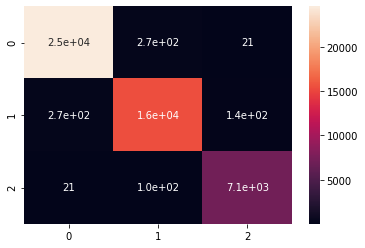

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True);

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     24852
           1       0.98      0.97      0.98     15910
           2       0.98      0.98      0.98      7271

    accuracy                           0.98     48033
   macro avg       0.98      0.98      0.98     48033
weighted avg       0.98      0.98      0.98     48033



## Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
accuracy_score(y_test,y_pred)

0.9764328690691816

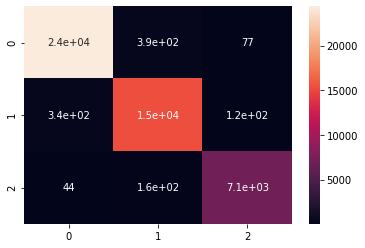

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True);

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     24852
           1       0.98      0.97      0.97     15910
           2       0.98      0.98      0.98      7271

    accuracy                           0.98     48033
   macro avg       0.98      0.98      0.98     48033
weighted avg       0.98      0.98      0.98     48033



## ANN

In [ ]:
# convert dataframes to narray
X_train,X_test,y_train,y_test = X_train.values,X_test.values,y_train.values,y_test.values

In [ ]:
# build ann
i = Input(shape = X_train[0].shape)
x = Dense(units = 64, activation = 'relu')(i)
x = Dropout(0.3)(x)
x = Dense(units = 32, activation = 'relu')(x)
x = Dropout(0.3)(x)
x = Dense(units = 3, activation = 'softmax')(x)

model = Model(i,x)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 2,883
Trainable params: 2,883
Non-trainable params: 0
____________________________________________________

In [ ]:
model.compile(optimizer = Adam(0.0001),loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
r = model.fit(X_train,y_train,epochs = 10,validation_data = (X_test,y_test))

Epoch 1/10
4503/4503 [==============================] - 6s 1ms/step - loss: 68.5097 - accuracy: 0.4713 - val_loss: 2.5111 - val_accuracy: 0.3763
Epoch 2/10
4503/4503 [==============================] - 6s 1ms/step - loss: 4.8582 - accuracy: 0.4651 - val_loss: 1.1670 - val_accuracy: 0.5174
Epoch 3/10
4503/4503 [==============================] - 6s 1ms/step - loss: 1.4584 - accuracy: 0.5146 - val_loss: 1.0020 - val_accuracy: 0.5174
Epoch 4/10
4503/4503 [==============================] - 6s 1ms/step - loss: 1.1307 - accuracy: 0.5162 - val_loss: 0.9930 - val_accuracy: 0.5174
Epoch 5/10
4503/4503 [==============================] - 6s 1ms/step - loss: 1.0267 - accuracy: 0.5163 - val_loss: 0.9929 - val_accuracy: 0.5174
Epoch 6/10
4503/4503 [==============================] - 6s 1ms/step - loss: 1.0035 - accuracy: 0.5159 - val_loss: 0.9797 - val_accuracy: 0.5174
Epoch 7/10
4503/4503 [==============================] - 6s 1ms/step - loss: 1.0062 - accuracy: 0.5155 - val_loss: 0.9633 - val_accuracy

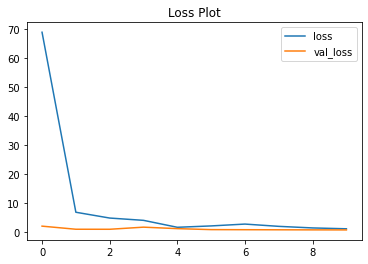

In [ ]:
plt.title('Loss Plot')
plt.plot(r.history['loss'],label = 'loss')
plt.plot(r.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

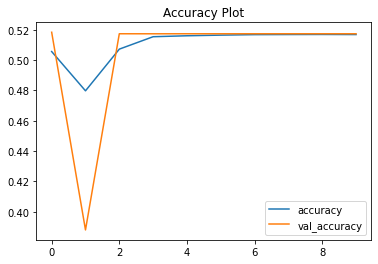

In [ ]:
plt.title('Accuracy Plot')
plt.plot(r.history['accuracy'],label = 'accuracy')
plt.plot(r.history['val_accuracy'],label = 'val_accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_test).argmax(axis = 1)

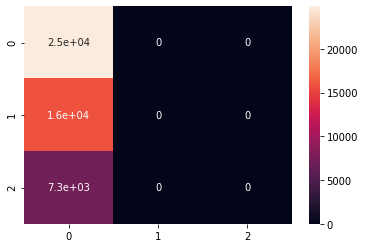

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True);

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68     24852
           1       0.00      0.00      0.00     15910
           2       0.00      0.00      0.00      7271

    accuracy                           0.52     48033
   macro avg       0.17      0.33      0.23     48033
weighted avg       0.27      0.52      0.35     48033



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
